<a href="https://colab.research.google.com/github/jmontano1987/pdg/blob/main/Proyecto_de_Grado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto de Grado**

**Título:** Modelo para la detección de Noticias Falsas en tweets con formato de texto en el contexto político colombiano para las elecciones del año 2022.

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Montaño M.

#**Instalaciones**

In [1]:
!pip install tweepy
!pip3 install tqdm
!pip install matplotlib
!pip install wordcloud
!spacy download es_core_news_sm
!pip install unidecode
!pip install --upgrade openpyxl

     |████████████████████████████████| 16.2 MB 5.3 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=fbde5d52c7b14bc66000af4e8576d575401193039e3cd6b32e3c6e73b3a6ef15
  Stored in directory: /tmp/pip-ephem-wheel-cache-gsz_y_d8/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
     |████████████████████████████████| 235 kB 5.2 MB/s 


#**Librerias**

In [1]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import requests

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [2]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [3]:
#Funcion para obtener los tweets de un usuario especifio de twitter
def get_tweets(api,username):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username).items()):
      tweets[tweet.id]= {
          'text': tweet.text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [4]:
def remove_newlines_tabs(text):
 # Remover saltos de linea
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [5]:
def remove_whitespace(text):
  # Remover espacios en blanco
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    return text    

In [6]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [7]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))


In [8]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [9]:
stoplist = stopwords.words('spanish') 
stoplist = set(stoplist)
def remove_stopwords(text):
    # Remover stop words
    # repr() function actually gives the precise information about the string
    text = repr(text)
    # Texto sin stopwords
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [10]:
nlp = spacy.load('es_core_news_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [11]:
def remove_links(text): 
    # Remover urls 
    text=re.sub('https://','',text)
    text=re.sub('opr-littps://','',text)
    return text

In [12]:
def remove_numbers(text):
    # Remover numeros
    formatted_text = re.sub(r"[0-9]+", ' ', text)
    return formatted_text

In [13]:
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):
      
    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text)

    if links == True: #remove links
        data = remove_links(data)
    
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
        
    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data)    
    
    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if lowercase == True: #Convertir mayusculas a minusculas
        data = lower_text(data)

    if numbers_remove == True: # Remover caracteres especiales
        data = remove_numbers(data)

    if stop_words == True: #Remover stopwords
        data = remove_stopwords(data)

    if lemmatization == True: #Converts words to lemma form.
       data = lemmatizer(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)
    
       
    return data

#**Twitter**

Credenciales Consumo API

In [14]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [15]:
# Autorización para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

In [16]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"juanmontan0")

0it [00:00, ?it/s]

In [17]:
df_tweets.head()

,text,created_at,author_name,author_handler,user_description,user_location,user_followers_count,user_created_at,user_following_count,user_verified,lang,tweet_hashtags,mention_names,mention_ids,n_retweets,n_favorites,is_retweet,id
1489046418262310918,prueba twitter 2022,02/02/2022 20:21:45,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1489046418262310918
1488863725675290625,prueba proyecto grado miercoles,02/02/2022 08:15:48,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488863725675290625
1488713846130941958,Prueba proyecto de grado febrero 2022,01/02/2022 22:20:14,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488713846130941958
1488526595614773253,Esto es una prueba para la tesis de grado,01/02/2022 09:56:10,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488526595614773253
1488522887137046543,prueba 3,01/02/2022 09:41:26,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488522887137046543


#**Cargar Corpus**

In [18]:
from google.colab import files
uploaded = files.upload()

Saving Corpus_Noticias_Falsas.xlsx to Corpus_Noticias_Falsas.xlsx


In [338]:
#df = pd.read_csv(io.BytesIO(uploaded['Corpus_Noticias_Falsas_Delimitado.csv']))

In [19]:
df=pd.read_excel("Corpus_Noticias_Falsas.xlsx")

In [20]:
from google.colab import files
uploaded = files.upload()

Saving train.xlsx to train.xlsx


In [21]:
df2=pd.read_excel("train.xlsx")

In [22]:
df

,ID,Category,Topic,Source,headline,Text,Link,Nombre
0,1,True,Politico,El tiempo,Duque dice que Eln se adjudicó atentado y busc...,El presidente Iván Duque condenó fuertemente e...,https://www.eltiempo.com/politica/gobierno/eln...,NaN
1,2,True,Politico,El espectador,"Gustavo Petro se reunirá con Pedro Sánchez, pr...","Gustavo Petro se reunirá con Pedro Sánchez, pr...",https://www.elespectador.com/politica/?utm_sou...,NaN
2,3,True,Politico,El tiempo,Marta Lucía Ramírez se queja por servicio en e...,Marta Lucía Ramírez se queja por servicio en e...,https://www.eltiempo.com/politica/gobierno/mar...,NaN
3,4,True,Politico,El espectador,"Elecciones de 2022 requieren mayor cuidado, po...","Elecciones de 2022 requieren mayor cuidado, po...",https://www.elespectador.com/politica/eleccion...,NaN
4,5,True,Politico,El Nuevo Siglo,Procuraduría citó a mandatarios por fiestas en...,ANTE LA expansión de la variante ómicron en el...,https://www.elnuevosiglo.com.co/articulos/01-0...,NaN
...,...,...,...,...,...,...,...,...
492,496,True,Politico,El colombiano,Destruyen valla del Partido Comunes en Puerto ...,Los pasacalles de la campaña de Comunes en Pue...,https://www.elcolombiano.com/colombia/politica...,JM
493,497,True,Politico,El colombiano,"“Cuando la corrupción llega, hay que buscar re...",En medio de uno de los momentos más difíciles ...,https://www.elcolombiano.com/colombia/politica...,JM
494,498,True,Politico,El colombiano,Este sábado empieza la inscripción de candidat...,Entre el sábado 29 de enero y el viernes 11 de...,https://www.elcolombiano.com/colombia/politica...,JM
495,499,True,Politico,El colombiano,Corte “no vio a profundidad lo que se ha logra...,El presidente Iván Duque respondió a la decisi...,https://www.elcolombiano.com/colombia/respuest...,JM


In [23]:
df2

,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...
...,...,...,...,...,...,...,...
671,672,Fake,Entertainment,El Dizque,Madonna será la nueva imagen del Chocolate Abu...,Madonna será la nueva imagen del Chocolate Abu...,https://www.eldizque.com/madonna-sera-la-nueva...
672,673,True,Entertainment,Radio Formula,"Filtran material íntimo de Zelina Vega, luchad...","Filtran material íntimo de Zelina Vega, luchad...",http://www.radioformula.com.mx/notas.asp?Idn=7...
673,674,Fake,Entertainment,La Voz Popular,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,http://lavozpopular.com/cbs-planea-gran-herman...
674,675,Fake,Entertainment,El Dizque,TV Azteca anuncia que cambiará su nombre por u...,TV Azteca anuncia que cambiará su nombre por u...,https://www.eldizque.com/tv-azteca-anuncia-que...


In [24]:
df_temp=df.loc[:,['Category','Text']]
df_temp

,Category,Text
0,True,El presidente Iván Duque condenó fuertemente e...
1,True,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,True,Marta Lucía Ramírez se queja por servicio en e...
3,True,"Elecciones de 2022 requieren mayor cuidado, po..."
4,True,ANTE LA expansión de la variante ómicron en el...
...,...,...
492,True,Los pasacalles de la campaña de Comunes en Pue...
493,True,En medio de uno de los momentos más difíciles ...
494,True,Entre el sábado 29 de enero y el viernes 11 de...
495,True,El presidente Iván Duque respondió a la decisi...


In [25]:
df_temp2=df2.loc[:,['Category','Text']]
df_temp2

,Category,Text
0,Fake,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR..."
1,Fake,"La palabra ""haiga"", aceptada por la RAE La Rea..."
2,Fake,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3,True,UNAM capacitará a maestros para aprobar prueba...
4,Fake,Alerta: pretenden aprobar libros escolares con...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [26]:
df_temp.Category.value_counts()

True    260
Fake    237
Name: Category, dtype: int64

In [27]:
df_temp2.Category.value_counts()

Fake    338
True    338
Name: Category, dtype: int64

In [28]:
print(df.Text.iloc[0])

El presidente Iván Duque condenó fuertemente el atentado terrorista que se presentó en la noche de este viernes, 7 de enero, contra miembros del Escuadrón Móvil Antidisturbios (Esmad) en la ciudad de Cali.


In [29]:
df_base=pd.concat([df_temp,df_temp2], axis=0, ignore_index=False)
df_base

,Category,Text
0,True,El presidente Iván Duque condenó fuertemente e...
1,True,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,True,Marta Lucía Ramírez se queja por servicio en e...
3,True,"Elecciones de 2022 requieren mayor cuidado, po..."
4,True,ANTE LA expansión de la variante ómicron en el...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [30]:
df_base.Category.value_counts()

True    598
Fake    575
Name: Category, dtype: int64

In [31]:
df=df_base

#**Preprocesamiento**

* Convertir Mayusculas a minusculas
* Remover links
* Remover números
* Remover signos de puntuación
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematización

In [33]:
List_News = df['Text'].to_list()
Final_News = []
Complete_Content = []
for news in List_News:
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df['Processed_Text'] = Complete_Content

In [34]:
print(df.Processed_Text.iloc[0])

 el presidente ivan duque condenar fuertemente atentar terrorista presentar noche viernes enero miembro escuadron movil antidisturbios esmad ciudad cali 


In [35]:
print(df.Text.iloc[0])

El presidente Iván Duque condenó fuertemente el atentado terrorista que se presentó en la noche de este viernes, 7 de enero, contra miembros del Escuadrón Móvil Antidisturbios (Esmad) en la ciudad de Cali.


In [36]:
real_news = df[df['Category'] == 'True']
real_news

,Category,Text,Processed_Text
0,True,El presidente Iván Duque condenó fuertemente e...,el presidente ivan duque condenar fuertemente...
1,True,"Gustavo Petro se reunirá con Pedro Sánchez, pr...",gustavo petro reunira pedro sanchez president...
2,True,Marta Lucía Ramírez se queja por servicio en e...,marta lucio ramirez quejar servicio call cent...
3,True,"Elecciones de 2022 requieren mayor cuidado, po...",elección requerir mayor cuidar menos informac...
4,True,ANTE LA expansión de la variante ómicron en el...,ante expansion variante omicron territorio na...
...,...,...,...
662,True,CHICHARITO 'ENCIENDE' EL INSTAGRAM DE YUYA\nEl...,chicharito encender instagram yuya atacante m...
665,True,Elena Poniatowska: 'AMLO será un presidente mu...,elena poniatowska amlo sera presidente cercan...
667,True,"Donald Trump, el hombre que «amaba» a las muje...",donald trump hombre amar mujer mas bello plan...
670,True,Globos de Oro *NUMBER*: estos son los ganadore...,globo orar number ganador primero premio post...


In [37]:
fake_news = df[df['Category'] == 'Fake']
fake_news

,Category,Text,Processed_Text
32,Fake,#ÚLTIMA_HORA Le ordenaré a los empresarios de ...,ultimahora ordenar empresario colombia descon...
41,Fake,La plandemia solo fue creada para causar miedo...,lo plandemia solo crear causar miedo sometimi...
42,Fake,Cuarentena estricta en Bogotá este jueves 30 d...,cuarentena estricto bogota jueves diciembre v...
43,Fake,Esta Noche a partir de las 11:00 pm nadie podr...,este noche partir pm nadie pudrir callar cerr...
44,Fake,"CORONA VIRUS EN BUGA ""Invito a los bugueños a ...",coronar virus buga invitar buguenos mantener ...
...,...,...,...
669,Fake,"Maradona totalmente drogado confiesa ""Me quier...",maradona totalmente drogar confesar querer ga...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...,madonna sera nuevo imagen chocolate abuelita ...
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,cbs planear gran hermanar casar blanco trump ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...,tv azteca anunciar cambiar nombrar mas nacion...


# **Analitica Descriptiva**

## Word Cloud Fake News

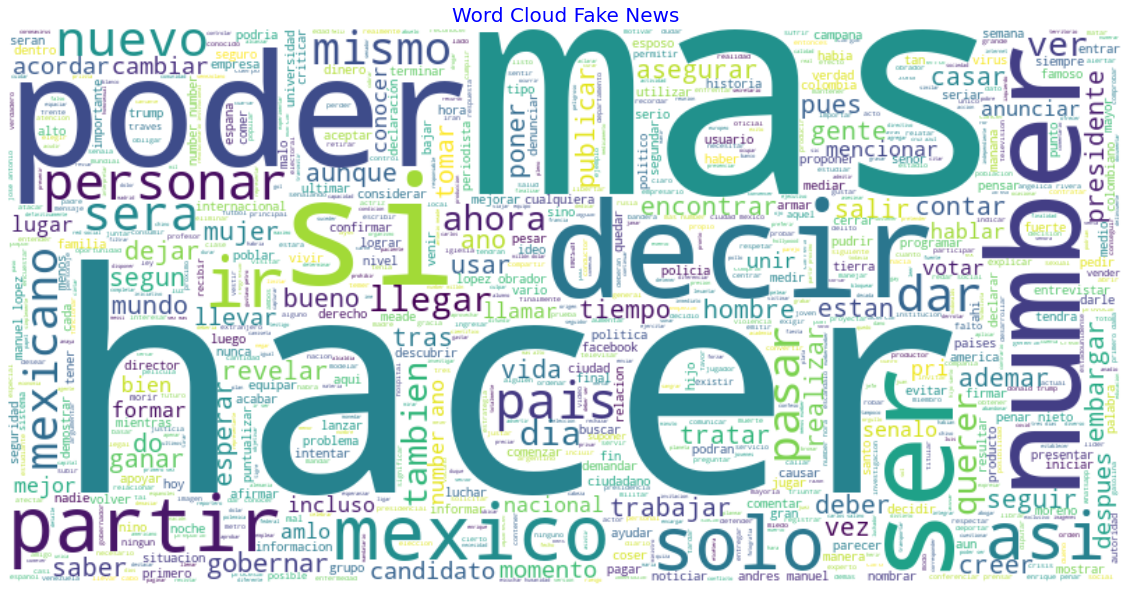

In [42]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud Real News

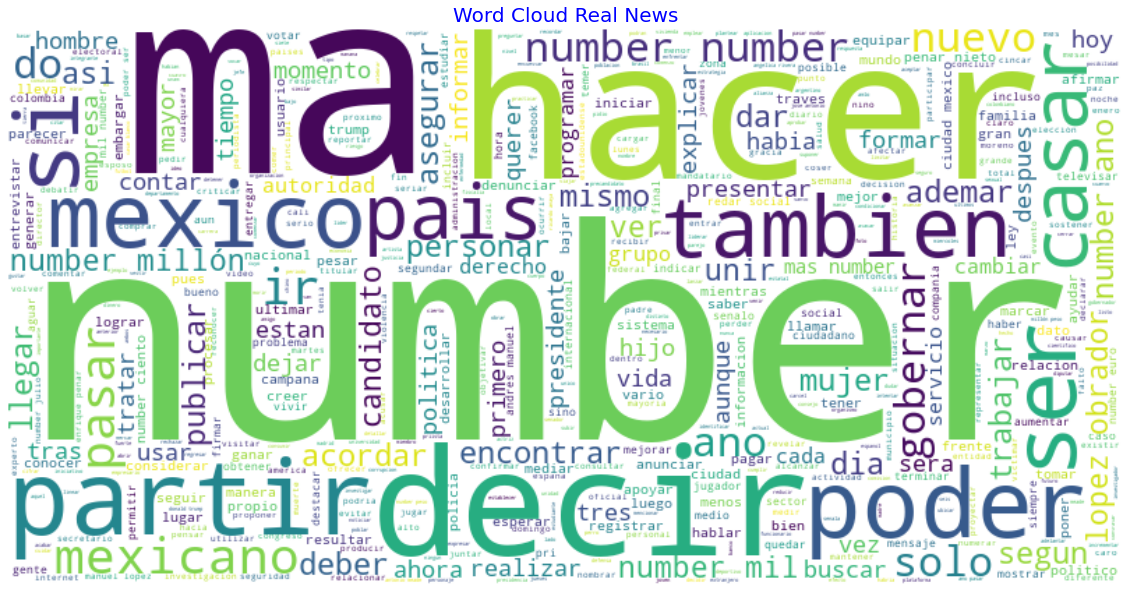

In [43]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Label coding

In [79]:
category_codes = {
     'True': 0,
    'Fake': 1
}

In [80]:
df['Codigo'] = df['Category']
df = df.replace({'Codigo':category_codes})

## Train-Test split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Text'], 
                                                    df['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## Text representation

In [90]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [91]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(938, 300)
(235, 300)


## Modelos de clasificación

### Randomized Search Cross Validation

In [92]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


### Random Search

In [93]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 5min 15s, sys: 1.11 s, total: 5min 17s
Wall time: 5min 18s


In [94]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.7995685535621638


## Grid Search Cross Validation

In [95]:
%%time

# Create the parameter grid based on the results of random search 
# NOTA: Revisar que los parametros a continuación coincidan con los parametros 
# encontrados en el random search

bootstrap = [False]
max_depth = [50, 100, 150]
max_features = ['auto']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [1000]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: user 4min 44s, sys: 781 ms, total: 4min 45s
Wall time: 4min 45s


In [96]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}

The mean accuracy of a model with these hyperparameters is:
0.7698924731182796


In [97]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5,
                       n_estimators=1000, random_state=8)

## Fit and performance

In [98]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5,
                       n_estimators=1000, random_state=8)

In [99]:
rfc_pred = best_rfc.predict(features_test)

### Training accuracy

In [100]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
1.0


### Test accuracy

In [101]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.774468085106383


## Confusion Matrix

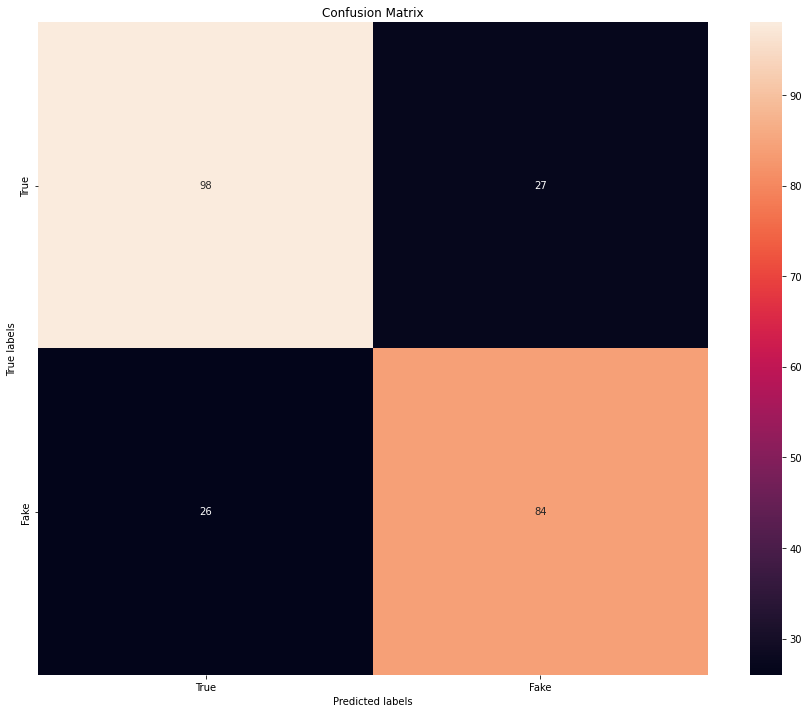

In [102]:
plt.rcParams['figure.figsize'] = [15, 12]
ax= plt.subplot()

cm = confusion_matrix(labels_test.to_list(), rfc_pred)

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(category_codes.keys())); ax.yaxis.set_ticklabels(list(category_codes.keys()));